# Input:8 Output:8

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow.keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.model_selection import KFold
from keras import callbacks 
from keras.constraints import maxnorm
import keras


In [3]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.80; # percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.2*4000=800

# spatial slicing dimensions
os = 8 # output slice size
ts = os # total input slice size including edge 8
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 512 # number of slices in one profile 4096/8=512



In [6]:
print("train_size:",train_size)
print("test_size:",test_size)

train_size: 3200
test_size: 800


In [7]:
# spatial slicing the profiles-------------------------------------------------------------

image=np.zeros((l2r*num,ts,nchan)) 
label=np.zeros((l2r*num,os)) 

for i in range(num):
    for a in range(l2r):
#cut each profile into 128 slices. 
#label: tau channel 
#1profile ..2profile...3 profile

        img= data[i, a*os:a*os+ts, 0:nchan] #input: 32 pixels for one slice, 3 channels 
        lb = data[i, a*os:a*os+os, nchan] #32 pixels for label,the tau channel is the label
        image[i*l2r+a]=img
        label[i*l2r+a]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) 

whole dataset features size:  (2048000, 8, 3) whole dataset label size:  (2048000, 8)


In [8]:
predictions = np.empty((test_size,8)) 
predictions.shape

(800, 8)

In [9]:
model_m = models.Sequential()
#model_m.add(layers.Embedding(input_dim=24,output_dim=72,input_shape=(ts,nchan)))
model_m.add(layers.LSTM(units=50, activation='tanh',return_sequences = True,input_shape=(ts,nchan))) #kernel size 6, 100 filters for each 3 channel
model_m.add(layers.LSTM(units=60, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
model_m.add(layers.LSTM(units=80, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
model_m.add(layers.LSTM(units=100, activation='tanh', return_sequences = True)) 

model_m.add(layers.Flatten())
model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

model_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 60)             26640     
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 80)             45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 100)            72400     
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6408      
Total params: 161,368
Trainable params: 161,368
Non-trainable params: 0
__________________________________________________

In [10]:
keras.utils.plot_model(model_m, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [11]:
# LSTM ------------------------------------------------------------------------------------------

def eval_model(train_image, test_image, train_label, test_label):

    model_m = models.Sequential()
    #model_m.add(layers.Embedding(input_dim=24,output_dim=72,input_shape=(ts,nchan)))
    model_m.add(layers.LSTM(units=50, activation='tanh',return_sequences = True,input_shape=(ts,nchan))) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.LSTM(units=60, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.LSTM(units=80, activation='tanh', return_sequences = True)) #kernel size 6, 100 filters for each 3 channel
    model_m.add(layers.LSTM(units=100, activation='tanh', return_sequences = True)) 

    model_m.add(layers.Flatten())
    model_m.add(layers.Dense(os, activation="linear"))#output slice size : 8

    model_m.summary()

    type2=tf.keras.metrics.RootMeanSquaredError() #RMSE
    ltype = 'mean_squared_error'
    bsize = 1024
    eps = 2000

    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ------------------------------------------------------------------------------------

    print('test result')
    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)

    mse = results[1]
    rmse = results[2] 
    
    return model_m,rmse,mse,history,predictions

In [13]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(image),'folds cross validation')
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),ts,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts,3))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

5 folds cross validation
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 409600  409601  409602 ... 2047997 2047998 2047999] TEST: [     0      1      2 ... 409597 409598 409599]
TRAIN: [      0       1       2 ... 2047997 2047998 2047999] TEST: [409600 409601 409602 ... 819197 819198 819199]
TRAIN: [      0       1       2 ... 2047997 2047998 2047999] TEST: [ 819200  819201  819202 ... 1228797 1228798 1228799]
TRAIN: [      0       1       2 ... 2047997 2047998 2047999] TEST: [1228800 1228801 1228802 ... 1638397 1638398 1638399]
TRAIN: [      0       1       2 ... 1638397 1638398 1638399] TEST: [1638400 1638401 1638402 ... 2047997 2047998 2047999]


In [15]:
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model_m,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 50)             10800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 60)             26640     
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 80)             45120     
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 100)            72400     
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 6408      
Total params: 161,368
Trainable params: 161,368
Non-trainable params: 0
________________________________________________

1400/1400 [==============================] - 17s 12ms/step - loss: 14.2715 - mean_squared_error: 14.2715 - root_mean_squared_error: 3.7776 - val_loss: 11.5780 - val_mean_squared_error: 11.5780 - val_root_mean_squared_error: 3.4026
Epoch 30/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 13.8246 - mean_squared_error: 13.8246 - root_mean_squared_error: 3.7179 - val_loss: 11.4727 - val_mean_squared_error: 11.4727 - val_root_mean_squared_error: 3.3871
Epoch 31/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 14.2295 - mean_squared_error: 14.2295 - root_mean_squared_error: 3.7721 - val_loss: 11.5230 - val_mean_squared_error: 11.5230 - val_root_mean_squared_error: 3.3946
Epoch 32/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 14.0987 - mean_squared_error: 14.0987 - root_mean_squared_error: 3.7547 - val_loss: 11.4193 - val_mean_squared_error: 11.4193 - val_root_mean_squared_error: 3.3792
Epoch 33/2000
1400/1400 [=========

1400/1400 [==============================] - 17s 12ms/step - loss: 9.8929 - mean_squared_error: 9.8929 - root_mean_squared_error: 3.1452 - val_loss: 9.8644 - val_mean_squared_error: 9.8644 - val_root_mean_squared_error: 3.1408
Epoch 63/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 9.4523 - mean_squared_error: 9.4523 - root_mean_squared_error: 3.0741 - val_loss: 8.5057 - val_mean_squared_error: 8.5057 - val_root_mean_squared_error: 2.9165
Epoch 64/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 9.4818 - mean_squared_error: 9.4818 - root_mean_squared_error: 3.0788 - val_loss: 9.3842 - val_mean_squared_error: 9.3842 - val_root_mean_squared_error: 3.0634
Epoch 65/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 9.4637 - mean_squared_error: 9.4637 - root_mean_squared_error: 3.0759 - val_loss: 7.9712 - val_mean_squared_error: 7.9712 - val_root_mean_squared_error: 2.8233
Epoch 66/2000
1400/1400 [=========================

1400/1400 [==============================] - 17s 12ms/step - loss: 6.3157 - mean_squared_error: 6.3157 - root_mean_squared_error: 2.5129 - val_loss: 6.2040 - val_mean_squared_error: 6.2040 - val_root_mean_squared_error: 2.4908
Epoch 97/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 6.3276 - mean_squared_error: 6.3276 - root_mean_squared_error: 2.5153 - val_loss: 6.1503 - val_mean_squared_error: 6.1503 - val_root_mean_squared_error: 2.4800
Epoch 98/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 6.0613 - mean_squared_error: 6.0613 - root_mean_squared_error: 2.4616 - val_loss: 6.3710 - val_mean_squared_error: 6.3710 - val_root_mean_squared_error: 2.5241
Epoch 99/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 6.6748 - mean_squared_error: 6.6748 - root_mean_squared_error: 2.5832 - val_loss: 6.5505 - val_mean_squared_error: 6.5505 - val_root_mean_squared_error: 2.5594
Epoch 100/2000
1400/1400 [========================

Epoch 130/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.8933 - mean_squared_error: 4.8933 - root_mean_squared_error: 2.2118 - val_loss: 6.3295 - val_mean_squared_error: 6.3295 - val_root_mean_squared_error: 2.5159
Epoch 131/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.6151 - mean_squared_error: 4.6151 - root_mean_squared_error: 2.1482 - val_loss: 5.8090 - val_mean_squared_error: 5.8090 - val_root_mean_squared_error: 2.4102
Epoch 132/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.7121 - mean_squared_error: 4.7121 - root_mean_squared_error: 2.1707 - val_loss: 5.8594 - val_mean_squared_error: 5.8594 - val_root_mean_squared_error: 2.4206
Epoch 133/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.5399 - mean_squared_error: 4.5399 - root_mean_squared_error: 2.1307 - val_loss: 5.6995 - val_mean_squared_error: 5.6995 - val_root_mean_squared_error: 2.3874
Epoch 134/2000
1400/1400 [======

Epoch 164/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.0310 - mean_squared_error: 4.0310 - root_mean_squared_error: 2.0058 - val_loss: 5.5701 - val_mean_squared_error: 5.5701 - val_root_mean_squared_error: 2.3601
Epoch 165/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 3.6648 - mean_squared_error: 3.6648 - root_mean_squared_error: 1.9143 - val_loss: 5.7242 - val_mean_squared_error: 5.7242 - val_root_mean_squared_error: 2.3925
Epoch 166/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 3.7694 - mean_squared_error: 3.7694 - root_mean_squared_error: 1.9414 - val_loss: 4.9542 - val_mean_squared_error: 4.9542 - val_root_mean_squared_error: 2.2258
Epoch 167/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 3.5788 - mean_squared_error: 3.5788 - root_mean_squared_error: 1.8915 - val_loss: 5.1456 - val_mean_squared_error: 5.1456 - val_root_mean_squared_error: 2.2684
Epoch 168/2000
1400/1400 [======

Epoch 198/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 3.3447 - mean_squared_error: 3.3447 - root_mean_squared_error: 1.8278 - val_loss: 5.1524 - val_mean_squared_error: 5.1524 - val_root_mean_squared_error: 2.2699
Epoch 199/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.9307 - mean_squared_error: 2.9307 - root_mean_squared_error: 1.7118 - val_loss: 5.0170 - val_mean_squared_error: 5.0170 - val_root_mean_squared_error: 2.2399
Epoch 200/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.7792 - mean_squared_error: 2.7792 - root_mean_squared_error: 1.6669 - val_loss: 4.7743 - val_mean_squared_error: 4.7743 - val_root_mean_squared_error: 2.1850
Epoch 201/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.9124 - mean_squared_error: 2.9124 - root_mean_squared_error: 1.7059 - val_loss: 4.5995 - val_mean_squared_error: 4.5995 - val_root_mean_squared_error: 2.1446
Epoch 202/2000
1400/1400 [======

Epoch 232/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.5707 - mean_squared_error: 2.5707 - root_mean_squared_error: 1.6030 - val_loss: 4.7669 - val_mean_squared_error: 4.7669 - val_root_mean_squared_error: 2.1833
Epoch 233/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.3093 - mean_squared_error: 2.3093 - root_mean_squared_error: 1.5195 - val_loss: 4.3674 - val_mean_squared_error: 4.3674 - val_root_mean_squared_error: 2.0898
Epoch 234/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.6340 - mean_squared_error: 2.6340 - root_mean_squared_error: 1.6212 - val_loss: 4.6385 - val_mean_squared_error: 4.6385 - val_root_mean_squared_error: 2.1537
Epoch 235/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.3733 - mean_squared_error: 2.3733 - root_mean_squared_error: 1.5404 - val_loss: 4.3298 - val_mean_squared_error: 4.3298 - val_root_mean_squared_error: 2.0808
Epoch 236/2000
1400/1400 [======

Epoch 266/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.2966 - mean_squared_error: 2.2966 - root_mean_squared_error: 1.5141 - val_loss: 4.3547 - val_mean_squared_error: 4.3547 - val_root_mean_squared_error: 2.0868
Epoch 267/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.0177 - mean_squared_error: 2.0177 - root_mean_squared_error: 1.4202 - val_loss: 4.4393 - val_mean_squared_error: 4.4393 - val_root_mean_squared_error: 2.1070
Epoch 268/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.0357 - mean_squared_error: 2.0357 - root_mean_squared_error: 1.4267 - val_loss: 4.3268 - val_mean_squared_error: 4.3268 - val_root_mean_squared_error: 2.0801
Epoch 269/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.0880 - mean_squared_error: 2.0880 - root_mean_squared_error: 1.4450 - val_loss: 4.1801 - val_mean_squared_error: 4.1801 - val_root_mean_squared_error: 2.0445
Epoch 270/2000
1400/1400 [======

1400/1400 [==============================] - 18s 13ms/step - loss: 1.7991 - mean_squared_error: 1.7991 - root_mean_squared_error: 1.3407 - val_loss: 4.0435 - val_mean_squared_error: 4.0435 - val_root_mean_squared_error: 2.0109
Epoch 300/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7823 - mean_squared_error: 1.7823 - root_mean_squared_error: 1.3348 - val_loss: 4.0985 - val_mean_squared_error: 4.0985 - val_root_mean_squared_error: 2.0245
Epoch 301/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7775 - mean_squared_error: 1.7775 - root_mean_squared_error: 1.3331 - val_loss: 4.3587 - val_mean_squared_error: 4.3587 - val_root_mean_squared_error: 2.0878
Epoch 302/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7842 - mean_squared_error: 1.7842 - root_mean_squared_error: 1.3356 - val_loss: 4.0467 - val_mean_squared_error: 4.0467 - val_root_mean_squared_error: 2.0116
Epoch 303/2000
1400/1400 [=====================

1400/1400 [==============================] - 17s 12ms/step - loss: 2.0530 - mean_squared_error: 2.0530 - root_mean_squared_error: 1.4302 - val_loss: 3.8501 - val_mean_squared_error: 3.8501 - val_root_mean_squared_error: 1.9622
Epoch 333/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 1.4900 - mean_squared_error: 1.4900 - root_mean_squared_error: 1.2206 - val_loss: 3.8351 - val_mean_squared_error: 3.8351 - val_root_mean_squared_error: 1.9583
Epoch 334/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.6204 - mean_squared_error: 1.6204 - root_mean_squared_error: 1.2726 - val_loss: 3.9301 - val_mean_squared_error: 3.9301 - val_root_mean_squared_error: 1.9824
Epoch 335/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.5891 - mean_squared_error: 1.5891 - root_mean_squared_error: 1.2604 - val_loss: 4.0055 - val_mean_squared_error: 4.0055 - val_root_mean_squared_error: 2.0014
Epoch 336/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 1.3716 - mean_squared_error: 1.3716 - root_mean_squared_error: 1.1711 - val_loss: 4.0918 - val_mean_squared_error: 4.0918 - val_root_mean_squared_error: 2.0228
Epoch 366/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7329 - mean_squared_error: 1.7329 - root_mean_squared_error: 1.3152 - val_loss: 3.5963 - val_mean_squared_error: 3.5963 - val_root_mean_squared_error: 1.8964
Epoch 367/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.3007 - mean_squared_error: 1.3007 - root_mean_squared_error: 1.1403 - val_loss: 3.5891 - val_mean_squared_error: 3.5891 - val_root_mean_squared_error: 1.8945
Epoch 368/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7194 - mean_squared_error: 1.7194 - root_mean_squared_error: 1.3078 - val_loss: 3.7166 - val_mean_squared_error: 3.7166 - val_root_mean_squared_error: 1.9278
Epoch 369/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 1.4895 - mean_squared_error: 1.4895 - root_mean_squared_error: 1.2189 - val_loss: 3.5812 - val_mean_squared_error: 3.5812 - val_root_mean_squared_error: 1.8924
Epoch 399/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.2741 - mean_squared_error: 1.2741 - root_mean_squared_error: 1.1285 - val_loss: 3.6408 - val_mean_squared_error: 3.6408 - val_root_mean_squared_error: 1.9081
Epoch 400/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.3029 - mean_squared_error: 1.3029 - root_mean_squared_error: 1.1414 - val_loss: 3.8291 - val_mean_squared_error: 3.8291 - val_root_mean_squared_error: 1.9568
Epoch 401/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.3198 - mean_squared_error: 1.3198 - root_mean_squared_error: 1.1482 - val_loss: 3.6426 - val_mean_squared_error: 3.6426 - val_root_mean_squared_error: 1.9086
Epoch 402/2000
1400/1400 [=====================

Epoch 432/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.1158 - mean_squared_error: 1.1158 - root_mean_squared_error: 1.0561 - val_loss: 3.7269 - val_mean_squared_error: 3.7269 - val_root_mean_squared_error: 1.9305
Epoch 433/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.4540 - mean_squared_error: 1.4540 - root_mean_squared_error: 1.2055 - val_loss: 3.5034 - val_mean_squared_error: 3.5034 - val_root_mean_squared_error: 1.8717
Epoch 434/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.1210 - mean_squared_error: 1.1210 - root_mean_squared_error: 1.0587 - val_loss: 3.4541 - val_mean_squared_error: 3.4541 - val_root_mean_squared_error: 1.8585
Epoch 435/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.4145 - mean_squared_error: 1.4145 - root_mean_squared_error: 1.1852 - val_loss: 3.6682 - val_mean_squared_error: 3.6682 - val_root_mean_squared_error: 1.9153
Epoch 436/2000
1400/1400 [======

1400/1400 [==============================] - 18s 13ms/step - loss: 1.1210 - mean_squared_error: 1.1210 - root_mean_squared_error: 1.0584 - val_loss: 3.6690 - val_mean_squared_error: 3.6690 - val_root_mean_squared_error: 1.9155
Epoch 466/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.1534 - mean_squared_error: 1.1534 - root_mean_squared_error: 1.0736 - val_loss: 3.5145 - val_mean_squared_error: 3.5145 - val_root_mean_squared_error: 1.8747
Epoch 467/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.1368 - mean_squared_error: 1.1368 - root_mean_squared_error: 1.0659 - val_loss: 3.5133 - val_mean_squared_error: 3.5133 - val_root_mean_squared_error: 1.8744
Epoch 468/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7718 - mean_squared_error: 1.7718 - root_mean_squared_error: 1.3245 - val_loss: 3.4069 - val_mean_squared_error: 3.4069 - val_root_mean_squared_error: 1.8458
Epoch 469/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 1.0798 - mean_squared_error: 1.0798 - root_mean_squared_error: 1.0375 - val_loss: 3.3986 - val_mean_squared_error: 3.3986 - val_root_mean_squared_error: 1.8435
Epoch 499/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.0998 - mean_squared_error: 1.0998 - root_mean_squared_error: 1.0478 - val_loss: 3.4263 - val_mean_squared_error: 3.4263 - val_root_mean_squared_error: 1.8510
Epoch 500/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.4063 - mean_squared_error: 1.4063 - root_mean_squared_error: 1.1835 - val_loss: 3.4312 - val_mean_squared_error: 3.4312 - val_root_mean_squared_error: 1.8523
Epoch 501/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 0.9639 - mean_squared_error: 0.9639 - root_mean_squared_error: 0.9817 - val_loss: 3.4479 - val_mean_squared_error: 3.4479 - val_root_mean_squared_error: 1.8569
Epoch 502/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 1.0927 - mean_squared_error: 1.0927 - root_mean_squared_error: 1.0450 - val_loss: 3.5453 - val_mean_squared_error: 3.5453 - val_root_mean_squared_error: 1.8829
Epoch 532/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 0.9670 - mean_squared_error: 0.9670 - root_mean_squared_error: 0.9830 - val_loss: 3.4079 - val_mean_squared_error: 3.4079 - val_root_mean_squared_error: 1.8461
Epoch 533/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 0.9492 - mean_squared_error: 0.9492 - root_mean_squared_error: 0.9737 - val_loss: 3.4099 - val_mean_squared_error: 3.4099 - val_root_mean_squared_error: 1.8466
Epoch 534/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 0.9439 - mean_squared_error: 0.9439 - root_mean_squared_error: 0.9715 - val_loss: 3.3438 - val_mean_squared_error: 3.3438 - val_root_mean_squared_error: 1.8286
Epoch 535/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 17.5871 - mean_squared_error: 17.5871 - root_mean_squared_error: 4.1936 - val_loss: 13.8547 - val_mean_squared_error: 13.8547 - val_root_mean_squared_error: 3.7222
Epoch 14/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 15.2535 - mean_squared_error: 15.2535 - root_mean_squared_error: 3.9054 - val_loss: 12.9668 - val_mean_squared_error: 12.9668 - val_root_mean_squared_error: 3.6009
Epoch 15/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 14.9543 - mean_squared_error: 14.9543 - root_mean_squared_error: 3.8662 - val_loss: 12.0868 - val_mean_squared_error: 12.0868 - val_root_mean_squared_error: 3.4766
Epoch 16/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 14.4639 - mean_squared_error: 14.4639 - root_mean_squared_error: 3.8030 - val_loss: 13.6758 - val_mean_squared_error: 13.6758 - val_root_mean_squared_error: 3.6981
Epoch 17/2000
1400/1400 [=========

1400/1400 [==============================] - 18s 13ms/step - loss: 10.0592 - mean_squared_error: 10.0592 - root_mean_squared_error: 3.1711 - val_loss: 8.9015 - val_mean_squared_error: 8.9015 - val_root_mean_squared_error: 2.9835
Epoch 47/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 9.8563 - mean_squared_error: 9.8563 - root_mean_squared_error: 3.1393 - val_loss: 10.7282 - val_mean_squared_error: 10.7282 - val_root_mean_squared_error: 3.2754
Epoch 48/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 9.7262 - mean_squared_error: 9.7262 - root_mean_squared_error: 3.1183 - val_loss: 10.3027 - val_mean_squared_error: 10.3027 - val_root_mean_squared_error: 3.2098
Epoch 49/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 9.7124 - mean_squared_error: 9.7124 - root_mean_squared_error: 3.1161 - val_loss: 8.8088 - val_mean_squared_error: 8.8088 - val_root_mean_squared_error: 2.9680
Epoch 50/2000
1400/1400 [===================

1400/1400 [==============================] - 18s 13ms/step - loss: 6.7263 - mean_squared_error: 6.7263 - root_mean_squared_error: 2.5931 - val_loss: 7.6251 - val_mean_squared_error: 7.6251 - val_root_mean_squared_error: 2.7614
Epoch 80/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 6.4955 - mean_squared_error: 6.4955 - root_mean_squared_error: 2.5483 - val_loss: 9.2765 - val_mean_squared_error: 9.2765 - val_root_mean_squared_error: 3.0457
Epoch 81/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 6.5983 - mean_squared_error: 6.5983 - root_mean_squared_error: 2.5671 - val_loss: 6.6236 - val_mean_squared_error: 6.6236 - val_root_mean_squared_error: 2.5736
Epoch 82/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 5.8656 - mean_squared_error: 5.8656 - root_mean_squared_error: 2.4216 - val_loss: 6.6696 - val_mean_squared_error: 6.6696 - val_root_mean_squared_error: 2.5826
Epoch 83/2000
1400/1400 [=========================

Epoch 113/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.4241 - mean_squared_error: 4.4241 - root_mean_squared_error: 2.1029 - val_loss: 6.7490 - val_mean_squared_error: 6.7490 - val_root_mean_squared_error: 2.5979
Epoch 114/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 4.4637 - mean_squared_error: 4.4637 - root_mean_squared_error: 2.1123 - val_loss: 6.0234 - val_mean_squared_error: 6.0234 - val_root_mean_squared_error: 2.4543
Epoch 115/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.6958 - mean_squared_error: 4.6958 - root_mean_squared_error: 2.1668 - val_loss: 5.9771 - val_mean_squared_error: 5.9771 - val_root_mean_squared_error: 2.4448
Epoch 116/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 4.2522 - mean_squared_error: 4.2522 - root_mean_squared_error: 2.0620 - val_loss: 7.5923 - val_mean_squared_error: 7.5923 - val_root_mean_squared_error: 2.7554
Epoch 117/2000
1400/1400 [======

1400/1400 [==============================] - 18s 13ms/step - loss: 3.4325 - mean_squared_error: 3.4325 - root_mean_squared_error: 1.8526 - val_loss: 7.2934 - val_mean_squared_error: 7.2934 - val_root_mean_squared_error: 2.7006
Epoch 147/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.7380 - mean_squared_error: 3.7380 - root_mean_squared_error: 1.9316 - val_loss: 5.7703 - val_mean_squared_error: 5.7703 - val_root_mean_squared_error: 2.4021
Epoch 148/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.6252 - mean_squared_error: 3.6252 - root_mean_squared_error: 1.9034 - val_loss: 6.2356 - val_mean_squared_error: 6.2356 - val_root_mean_squared_error: 2.4971
Epoch 149/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.7872 - mean_squared_error: 3.7872 - root_mean_squared_error: 1.9455 - val_loss: 5.3514 - val_mean_squared_error: 5.3514 - val_root_mean_squared_error: 2.3133
Epoch 150/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 15.6171 - mean_squared_error: 15.6171 - root_mean_squared_error: 3.9518 - val_loss: 12.8548 - val_mean_squared_error: 12.8548 - val_root_mean_squared_error: 3.5854
Epoch 14/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 15.3040 - mean_squared_error: 15.3040 - root_mean_squared_error: 3.9118 - val_loss: 14.9288 - val_mean_squared_error: 14.9288 - val_root_mean_squared_error: 3.8638
Epoch 15/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 15.6982 - mean_squared_error: 15.6982 - root_mean_squared_error: 3.9617 - val_loss: 12.3322 - val_mean_squared_error: 12.3322 - val_root_mean_squared_error: 3.5117
Epoch 16/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 15.3844 - mean_squared_error: 15.3844 - root_mean_squared_error: 3.9222 - val_loss: 12.3240 - val_mean_squared_error: 12.3240 - val_root_mean_squared_error: 3.5106
Epoch 17/2000
1400/1400 [=========

1400/1400 [==============================] - 18s 13ms/step - loss: 11.1109 - mean_squared_error: 11.1109 - root_mean_squared_error: 3.3329 - val_loss: 9.5004 - val_mean_squared_error: 9.5004 - val_root_mean_squared_error: 3.0823
Epoch 47/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 10.9435 - mean_squared_error: 10.9435 - root_mean_squared_error: 3.3080 - val_loss: 9.8076 - val_mean_squared_error: 9.8076 - val_root_mean_squared_error: 3.1317
Epoch 48/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 10.4860 - mean_squared_error: 10.4860 - root_mean_squared_error: 3.2380 - val_loss: 9.2229 - val_mean_squared_error: 9.2229 - val_root_mean_squared_error: 3.0369
Epoch 49/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 10.2457 - mean_squared_error: 10.2457 - root_mean_squared_error: 3.2005 - val_loss: 8.9892 - val_mean_squared_error: 8.9892 - val_root_mean_squared_error: 2.9982
Epoch 50/2000
1400/1400 [=================

Epoch 80/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 7.3412 - mean_squared_error: 7.3412 - root_mean_squared_error: 2.7090 - val_loss: 6.8843 - val_mean_squared_error: 6.8843 - val_root_mean_squared_error: 2.6238
Epoch 81/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 7.3441 - mean_squared_error: 7.3441 - root_mean_squared_error: 2.7094 - val_loss: 7.0020 - val_mean_squared_error: 7.0020 - val_root_mean_squared_error: 2.6461
Epoch 82/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 6.8954 - mean_squared_error: 6.8954 - root_mean_squared_error: 2.6254 - val_loss: 7.5584 - val_mean_squared_error: 7.5584 - val_root_mean_squared_error: 2.7493
Epoch 83/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 7.1678 - mean_squared_error: 7.1678 - root_mean_squared_error: 2.6768 - val_loss: 7.1175 - val_mean_squared_error: 7.1175 - val_root_mean_squared_error: 2.6679
Epoch 84/2000
1400/1400 [===========

Epoch 114/2000
1400/1400 [==============================] - 20s 14ms/step - loss: 4.8484 - mean_squared_error: 4.8484 - root_mean_squared_error: 2.2015 - val_loss: 5.8622 - val_mean_squared_error: 5.8622 - val_root_mean_squared_error: 2.4212
Epoch 115/2000
1400/1400 [==============================] - 19s 13ms/step - loss: 4.8795 - mean_squared_error: 4.8795 - root_mean_squared_error: 2.2086 - val_loss: 6.6375 - val_mean_squared_error: 6.6375 - val_root_mean_squared_error: 2.5763
Epoch 116/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 5.4672 - mean_squared_error: 5.4672 - root_mean_squared_error: 2.3376 - val_loss: 6.9104 - val_mean_squared_error: 6.9104 - val_root_mean_squared_error: 2.6288
Epoch 117/2000
1400/1400 [==============================] - 19s 13ms/step - loss: 5.1539 - mean_squared_error: 5.1539 - root_mean_squared_error: 2.2694 - val_loss: 6.5296 - val_mean_squared_error: 6.5296 - val_root_mean_squared_error: 2.5553
Epoch 118/2000
1400/1400 [======

Epoch 148/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 4.2238 - mean_squared_error: 4.2238 - root_mean_squared_error: 2.0539 - val_loss: 5.6434 - val_mean_squared_error: 5.6434 - val_root_mean_squared_error: 2.3756
Epoch 149/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.0680 - mean_squared_error: 4.0680 - root_mean_squared_error: 2.0162 - val_loss: 6.5196 - val_mean_squared_error: 6.5196 - val_root_mean_squared_error: 2.5534
Epoch 150/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 4.7285 - mean_squared_error: 4.7285 - root_mean_squared_error: 2.1714 - val_loss: 5.4746 - val_mean_squared_error: 5.4746 - val_root_mean_squared_error: 2.3398
Epoch 151/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 4.1444 - mean_squared_error: 4.1444 - root_mean_squared_error: 2.0356 - val_loss: 5.5069 - val_mean_squared_error: 5.5069 - val_root_mean_squared_error: 2.3467
Epoch 152/2000
1400/1400 [======

1400/1400 [==============================] - 17s 12ms/step - loss: 3.5625 - mean_squared_error: 3.5625 - root_mean_squared_error: 1.8871 - val_loss: 5.0169 - val_mean_squared_error: 5.0169 - val_root_mean_squared_error: 2.2398
Epoch 182/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.0139 - mean_squared_error: 3.0139 - root_mean_squared_error: 1.7359 - val_loss: 4.7437 - val_mean_squared_error: 4.7437 - val_root_mean_squared_error: 2.1780
Epoch 183/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.3170 - mean_squared_error: 3.3170 - root_mean_squared_error: 1.8205 - val_loss: 5.2118 - val_mean_squared_error: 5.2118 - val_root_mean_squared_error: 2.2829
Epoch 184/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.1693 - mean_squared_error: 3.1693 - root_mean_squared_error: 1.7802 - val_loss: 5.1792 - val_mean_squared_error: 5.1792 - val_root_mean_squared_error: 2.2758
Epoch 185/2000
1400/1400 [=====================

Epoch 215/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.8617 - mean_squared_error: 2.8617 - root_mean_squared_error: 1.6902 - val_loss: 4.7146 - val_mean_squared_error: 4.7146 - val_root_mean_squared_error: 2.1713
Epoch 216/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.6881 - mean_squared_error: 2.6881 - root_mean_squared_error: 1.6387 - val_loss: 4.4626 - val_mean_squared_error: 4.4626 - val_root_mean_squared_error: 2.1125
Epoch 217/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.5875 - mean_squared_error: 2.5875 - root_mean_squared_error: 1.6078 - val_loss: 4.8342 - val_mean_squared_error: 4.8342 - val_root_mean_squared_error: 2.1987
Epoch 218/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.6448 - mean_squared_error: 2.6448 - root_mean_squared_error: 1.6259 - val_loss: 4.5424 - val_mean_squared_error: 4.5424 - val_root_mean_squared_error: 2.1313
Epoch 219/2000
1400/1400 [======

1400/1400 [==============================] - 18s 13ms/step - loss: 2.1192 - mean_squared_error: 2.1192 - root_mean_squared_error: 1.4557 - val_loss: 4.4618 - val_mean_squared_error: 4.4618 - val_root_mean_squared_error: 2.1123
Epoch 249/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.1796 - mean_squared_error: 2.1796 - root_mean_squared_error: 1.4758 - val_loss: 4.3323 - val_mean_squared_error: 4.3323 - val_root_mean_squared_error: 2.0814
Epoch 250/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.2008 - mean_squared_error: 2.2008 - root_mean_squared_error: 1.4834 - val_loss: 4.8890 - val_mean_squared_error: 4.8890 - val_root_mean_squared_error: 2.2111
Epoch 251/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.2522 - mean_squared_error: 2.2522 - root_mean_squared_error: 1.5006 - val_loss: 4.1620 - val_mean_squared_error: 4.1620 - val_root_mean_squared_error: 2.0401
Epoch 252/2000
1400/1400 [=====================

1400/1400 [==============================] - 17s 12ms/step - loss: 1.8681 - mean_squared_error: 1.8681 - root_mean_squared_error: 1.3658 - val_loss: 3.7801 - val_mean_squared_error: 3.7801 - val_root_mean_squared_error: 1.9443
Epoch 282/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7443 - mean_squared_error: 1.7443 - root_mean_squared_error: 1.3207 - val_loss: 3.9944 - val_mean_squared_error: 3.9944 - val_root_mean_squared_error: 1.9986
Epoch 283/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.0880 - mean_squared_error: 2.0880 - root_mean_squared_error: 1.4441 - val_loss: 3.7490 - val_mean_squared_error: 3.7490 - val_root_mean_squared_error: 1.9362
Epoch 284/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 1.6599 - mean_squared_error: 1.6599 - root_mean_squared_error: 1.2883 - val_loss: 4.2102 - val_mean_squared_error: 4.2102 - val_root_mean_squared_error: 2.0519
Epoch 285/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 1.5766 - mean_squared_error: 1.5766 - root_mean_squared_error: 1.2555 - val_loss: 3.6353 - val_mean_squared_error: 3.6353 - val_root_mean_squared_error: 1.9066
Epoch 315/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.6425 - mean_squared_error: 1.6425 - root_mean_squared_error: 1.2811 - val_loss: 3.8509 - val_mean_squared_error: 3.8509 - val_root_mean_squared_error: 1.9624
Epoch 316/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 1.7682 - mean_squared_error: 1.7682 - root_mean_squared_error: 1.3291 - val_loss: 3.7514 - val_mean_squared_error: 3.7514 - val_root_mean_squared_error: 1.9369
Epoch 317/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 1.4454 - mean_squared_error: 1.4454 - root_mean_squared_error: 1.2022 - val_loss: 4.1272 - val_mean_squared_error: 4.1272 - val_root_mean_squared_error: 2.0315
Epoch 318/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 19.9497 - mean_squared_error: 19.9497 - root_mean_squared_error: 4.4665 - val_loss: 16.3330 - val_mean_squared_error: 16.3330 - val_root_mean_squared_error: 4.0414
Epoch 6/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 19.8609 - mean_squared_error: 19.8609 - root_mean_squared_error: 4.4563 - val_loss: 16.2042 - val_mean_squared_error: 16.2042 - val_root_mean_squared_error: 4.0254
Epoch 7/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 19.6275 - mean_squared_error: 19.6275 - root_mean_squared_error: 4.4302 - val_loss: 15.8652 - val_mean_squared_error: 15.8652 - val_root_mean_squared_error: 3.9831
Epoch 8/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 19.8178 - mean_squared_error: 19.8178 - root_mean_squared_error: 4.4513 - val_loss: 15.8467 - val_mean_squared_error: 15.8467 - val_root_mean_squared_error: 3.9808
Epoch 9/2000
1400/1400 [=============

1400/1400 [==============================] - 18s 13ms/step - loss: 10.3910 - mean_squared_error: 10.3910 - root_mean_squared_error: 3.2233 - val_loss: 8.5313 - val_mean_squared_error: 8.5313 - val_root_mean_squared_error: 2.9208
Epoch 39/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 10.0282 - mean_squared_error: 10.0282 - root_mean_squared_error: 3.1666 - val_loss: 10.7304 - val_mean_squared_error: 10.7304 - val_root_mean_squared_error: 3.2757
Epoch 40/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 9.8757 - mean_squared_error: 9.8757 - root_mean_squared_error: 3.1420 - val_loss: 8.3352 - val_mean_squared_error: 8.3352 - val_root_mean_squared_error: 2.8871
Epoch 41/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 9.5066 - mean_squared_error: 9.5066 - root_mean_squared_error: 3.0831 - val_loss: 10.6171 - val_mean_squared_error: 10.6171 - val_root_mean_squared_error: 3.2584
Epoch 42/2000
1400/1400 [=================

1400/1400 [==============================] - 17s 12ms/step - loss: 5.1516 - mean_squared_error: 5.1516 - root_mean_squared_error: 2.2695 - val_loss: 5.6693 - val_mean_squared_error: 5.6693 - val_root_mean_squared_error: 2.3810
Epoch 72/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 4.9939 - mean_squared_error: 4.9939 - root_mean_squared_error: 2.2345 - val_loss: 5.3555 - val_mean_squared_error: 5.3555 - val_root_mean_squared_error: 2.3142
Epoch 73/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 5.1129 - mean_squared_error: 5.1129 - root_mean_squared_error: 2.2609 - val_loss: 5.8003 - val_mean_squared_error: 5.8003 - val_root_mean_squared_error: 2.4084
Epoch 74/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 5.1151 - mean_squared_error: 5.1151 - root_mean_squared_error: 2.2614 - val_loss: 5.4352 - val_mean_squared_error: 5.4352 - val_root_mean_squared_error: 2.3314
Epoch 75/2000
1400/1400 [=========================

1400/1400 [==============================] - 18s 13ms/step - loss: 3.4719 - mean_squared_error: 3.4719 - root_mean_squared_error: 1.8632 - val_loss: 4.6448 - val_mean_squared_error: 4.6448 - val_root_mean_squared_error: 2.1552
Epoch 105/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 3.5072 - mean_squared_error: 3.5072 - root_mean_squared_error: 1.8724 - val_loss: 4.5391 - val_mean_squared_error: 4.5391 - val_root_mean_squared_error: 2.1305
Epoch 106/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.4899 - mean_squared_error: 3.4899 - root_mean_squared_error: 1.8679 - val_loss: 4.8948 - val_mean_squared_error: 4.8948 - val_root_mean_squared_error: 2.2124
Epoch 107/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.4003 - mean_squared_error: 3.4003 - root_mean_squared_error: 1.8437 - val_loss: 5.1221 - val_mean_squared_error: 5.1221 - val_root_mean_squared_error: 2.2632
Epoch 108/2000
1400/1400 [=====================

Epoch 138/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.5125 - mean_squared_error: 2.5125 - root_mean_squared_error: 1.5847 - val_loss: 3.7803 - val_mean_squared_error: 3.7803 - val_root_mean_squared_error: 1.9443
Epoch 139/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.3289 - mean_squared_error: 2.3289 - root_mean_squared_error: 1.5259 - val_loss: 3.8299 - val_mean_squared_error: 3.8299 - val_root_mean_squared_error: 1.9570
Epoch 140/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 2.5535 - mean_squared_error: 2.5535 - root_mean_squared_error: 1.5973 - val_loss: 3.4249 - val_mean_squared_error: 3.4249 - val_root_mean_squared_error: 1.8507
Epoch 141/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.3235 - mean_squared_error: 2.3235 - root_mean_squared_error: 1.5242 - val_loss: 3.4820 - val_mean_squared_error: 3.4820 - val_root_mean_squared_error: 1.8660
Epoch 142/2000
1400/1400 [======

1400/1400 [==============================] - 18s 13ms/step - loss: 1.8241 - mean_squared_error: 1.8241 - root_mean_squared_error: 1.3505 - val_loss: 8.7986 - val_mean_squared_error: 8.7986 - val_root_mean_squared_error: 2.9662
Epoch 172/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.9160 - mean_squared_error: 2.9160 - root_mean_squared_error: 1.6958 - val_loss: 3.2729 - val_mean_squared_error: 3.2729 - val_root_mean_squared_error: 1.8091
Epoch 173/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7743 - mean_squared_error: 1.7743 - root_mean_squared_error: 1.3319 - val_loss: 3.3191 - val_mean_squared_error: 3.3191 - val_root_mean_squared_error: 1.8218
Epoch 174/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.8274 - mean_squared_error: 1.8274 - root_mean_squared_error: 1.3517 - val_loss: 3.4452 - val_mean_squared_error: 3.4452 - val_root_mean_squared_error: 1.8561
Epoch 175/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 1.6089 - mean_squared_error: 1.6089 - root_mean_squared_error: 1.2682 - val_loss: 3.5159 - val_mean_squared_error: 3.5159 - val_root_mean_squared_error: 1.8751
Epoch 205/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.6659 - mean_squared_error: 1.6659 - root_mean_squared_error: 1.2906 - val_loss: 3.3342 - val_mean_squared_error: 3.3342 - val_root_mean_squared_error: 1.8260
Epoch 206/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.5440 - mean_squared_error: 1.5440 - root_mean_squared_error: 1.2425 - val_loss: 3.2357 - val_mean_squared_error: 3.2357 - val_root_mean_squared_error: 1.7988
Epoch 207/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.7466 - mean_squared_error: 1.7466 - root_mean_squared_error: 1.3212 - val_loss: 3.1889 - val_mean_squared_error: 3.1889 - val_root_mean_squared_error: 1.7857
Epoch 208/2000
1400/1400 [=====================

1400/1400 [==============================] - 18s 13ms/step - loss: 1.3038 - mean_squared_error: 1.3038 - root_mean_squared_error: 1.1415 - val_loss: 4.3668 - val_mean_squared_error: 4.3668 - val_root_mean_squared_error: 2.0897
Epoch 238/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 2.3715 - mean_squared_error: 2.3715 - root_mean_squared_error: 1.5297 - val_loss: 3.3657 - val_mean_squared_error: 3.3657 - val_root_mean_squared_error: 1.8346
Epoch 239/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.3230 - mean_squared_error: 1.3230 - root_mean_squared_error: 1.1501 - val_loss: 3.1283 - val_mean_squared_error: 3.1283 - val_root_mean_squared_error: 1.7687
Epoch 240/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 1.3656 - mean_squared_error: 1.3656 - root_mean_squared_error: 1.1683 - val_loss: 3.1027 - val_mean_squared_error: 3.1027 - val_root_mean_squared_error: 1.7614
Epoch 241/2000
1400/1400 [=====================

Epoch 10/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 19.8199 - mean_squared_error: 19.8199 - root_mean_squared_error: 4.4519 - val_loss: 21.2104 - val_mean_squared_error: 21.2104 - val_root_mean_squared_error: 4.6055
Epoch 11/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 19.7357 - mean_squared_error: 19.7357 - root_mean_squared_error: 4.4424 - val_loss: 19.0930 - val_mean_squared_error: 19.0930 - val_root_mean_squared_error: 4.3696
Epoch 12/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 18.6214 - mean_squared_error: 18.6214 - root_mean_squared_error: 4.3144 - val_loss: 17.2371 - val_mean_squared_error: 17.2371 - val_root_mean_squared_error: 4.1518
Epoch 13/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 17.0815 - mean_squared_error: 17.0815 - root_mean_squared_error: 4.1323 - val_loss: 16.6580 - val_mean_squared_error: 16.6580 - val_root_mean_squared_error: 4.0814
Epoch 14/2000
1400/1

1400/1400 [==============================] - 17s 12ms/step - loss: 9.9999 - mean_squared_error: 9.9999 - root_mean_squared_error: 3.1621 - val_loss: 10.4636 - val_mean_squared_error: 10.4636 - val_root_mean_squared_error: 3.2348
Epoch 44/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 10.1751 - mean_squared_error: 10.1751 - root_mean_squared_error: 3.1895 - val_loss: 10.9347 - val_mean_squared_error: 10.9347 - val_root_mean_squared_error: 3.3068
Epoch 45/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 10.6077 - mean_squared_error: 10.6077 - root_mean_squared_error: 3.2557 - val_loss: 10.3703 - val_mean_squared_error: 10.3703 - val_root_mean_squared_error: 3.2203
Epoch 46/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 9.5001 - mean_squared_error: 9.5001 - root_mean_squared_error: 3.0814 - val_loss: 11.3013 - val_mean_squared_error: 11.3013 - val_root_mean_squared_error: 3.3617
Epoch 47/2000
1400/1400 [=============

1400/1400 [==============================] - 18s 13ms/step - loss: 6.1937 - mean_squared_error: 6.1937 - root_mean_squared_error: 2.4885 - val_loss: 7.7771 - val_mean_squared_error: 7.7771 - val_root_mean_squared_error: 2.7887
Epoch 77/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 6.2000 - mean_squared_error: 6.2000 - root_mean_squared_error: 2.4898 - val_loss: 7.8839 - val_mean_squared_error: 7.8839 - val_root_mean_squared_error: 2.8078
Epoch 78/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 6.0180 - mean_squared_error: 6.0180 - root_mean_squared_error: 2.4529 - val_loss: 7.9379 - val_mean_squared_error: 7.9379 - val_root_mean_squared_error: 2.8174
Epoch 79/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 6.0911 - mean_squared_error: 6.0911 - root_mean_squared_error: 2.4678 - val_loss: 8.1928 - val_mean_squared_error: 8.1928 - val_root_mean_squared_error: 2.8623
Epoch 80/2000
1400/1400 [=========================

1400/1400 [==============================] - 18s 13ms/step - loss: 4.4745 - mean_squared_error: 4.4745 - root_mean_squared_error: 2.1150 - val_loss: 7.5239 - val_mean_squared_error: 7.5239 - val_root_mean_squared_error: 2.7430
Epoch 110/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 4.6535 - mean_squared_error: 4.6535 - root_mean_squared_error: 2.1564 - val_loss: 7.5544 - val_mean_squared_error: 7.5544 - val_root_mean_squared_error: 2.7485
Epoch 111/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 5.6081 - mean_squared_error: 5.6081 - root_mean_squared_error: 2.3633 - val_loss: 7.0301 - val_mean_squared_error: 7.0301 - val_root_mean_squared_error: 2.6514
Epoch 112/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 4.2532 - mean_squared_error: 4.2532 - root_mean_squared_error: 2.0618 - val_loss: 7.7396 - val_mean_squared_error: 7.7396 - val_root_mean_squared_error: 2.7820
Epoch 113/2000
1400/1400 [=====================

1400/1400 [==============================] - 17s 12ms/step - loss: 3.5046 - mean_squared_error: 3.5046 - root_mean_squared_error: 1.8719 - val_loss: 6.7116 - val_mean_squared_error: 6.7116 - val_root_mean_squared_error: 2.5907
Epoch 143/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.5734 - mean_squared_error: 3.5734 - root_mean_squared_error: 1.8901 - val_loss: 7.1511 - val_mean_squared_error: 7.1511 - val_root_mean_squared_error: 2.6741
Epoch 144/2000
1400/1400 [==============================] - 17s 12ms/step - loss: 3.7421 - mean_squared_error: 3.7421 - root_mean_squared_error: 1.9335 - val_loss: 7.2242 - val_mean_squared_error: 7.2242 - val_root_mean_squared_error: 2.6878
Epoch 145/2000
1400/1400 [==============================] - 18s 13ms/step - loss: 3.7407 - mean_squared_error: 3.7407 - root_mean_squared_error: 1.9339 - val_loss: 6.7176 - val_mean_squared_error: 6.7176 - val_root_mean_squared_error: 2.5918
Epoch 146/2000
1400/1400 [=====================

In [16]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 4.8815 with standard deviation (1.4168)
Estimated RMSE 2.1873 with standard deviation (0.3116)


In [17]:
#quantitative reuslt: mean square error of test set
cv_scores

[3.623445987701416,
 7.2168192863464355,
 4.244461536407471,
 3.5439398288726807,
 5.778621196746826]

In [18]:
#quantitative reuslt: root mean square error of test set
cv_scores2

[1.90353524684906,
 2.6864140033721924,
 2.060209035873413,
 1.882535457611084,
 2.4038760662078857]

The optimal number of epochs is 126


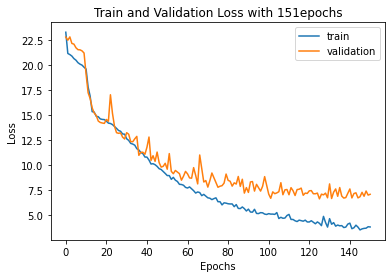

In [19]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [20]:
predict1=np.zeros((4096,))
for i in range((test_size-3)*l2r,(test_size-2)*l2r):
    predict1[(i-(test_size-3)*l2r)*os:(i-(test_size-3)*l2r+1)*os,]=predictions[i]
    
predict2=np.zeros((4096,))
for i in range((test_size-2)*l2r,(test_size-1)*l2r):
    predict2[(i-(test_size-2)*l2r)*os:(i-(test_size-2)*l2r+1)*os,]=predictions[i]
    
predict3=np.zeros((4096,))
for i in range((test_size-1)*l2r,test_size*l2r):
    predict3[(i-(test_size-1)*l2r)*os:(i-(test_size-1)*l2r+1)*os,]=predictions[i]

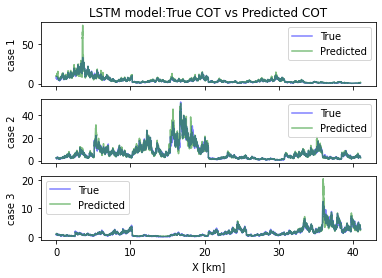

In [22]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/LSTM 8 predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"LSTM model:True COT vs Predicted COT")
ax.plot(x[:os*l2r],data[num-3,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict1,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r],data[num-2,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict2,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r],data[num-1,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict3,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

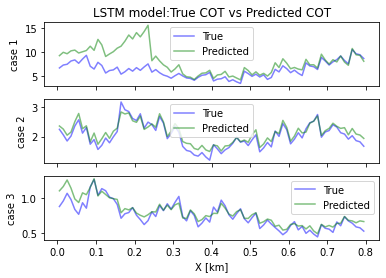

In [23]:
# plotting ----------------------------------------------------------------------------------------------------------------
fgnm = "plots/LSTM 8 predict"+"_"+'MSE'+"_"+str(1024)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_COT_values"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r"LSTM model:True COT vs Predicted COT")
ax.plot(x[:os*l2r][:80],data[num-3,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict1[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r][:80],data[num-2,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict2[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r][:80],data[num-1,:os*l2r,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r][:80],predict3[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')